# Notebook to visualize the results from LevSeq campaigns

Here we use the combined output from the campaigns and then visualize as heatmaps for various filters.

# Lineage analysis

In [1]:
import pandas as pd

output_dir = 'output/'
fig_dir = 'figs/'

lineage_df = pd.read_csv('lineage_summary.tsv', sep='\t')
lineage_df['name'] = [f'{l}_{n}' for l, n in lineage_df[['linage', 'name']].values]
lineage_df.dropna()
# Keep track of the parents for the LevSeq data
lineage_df['AA'] = [d.replace('*', '') for d in lineage_df['AA'].values]
parent_to_name = dict(zip(lineage_df.AA, lineage_df.name))
parents = list(lineage_df.AA.values)

In [2]:
from sciutil import SciUtil

u = SciUtil()

parent_name = 'H2NOH_G0'
variant_name = 'H2NOH_G7'

def get_hamming(df, parent_name, variant_name):
    parent = df[df['name'] == parent_name]['AA'].values[0]
    variant = df[df['name'] == variant_name]['AA'].values[0]
    len(parent), len(variant)
    # Since the same we can do hamming distance
    hamming_dist = 0
    variant_changes = []
    for i in range(0, len(parent)):
        if parent[i] != variant[i]:
            variant_changes.append(f'{parent[i]}{i+1}{variant[i]}')
            hamming_dist += 1
    u.dp([f'Hamming distance between {parent_name} and {variant_name}', hamming_dist, '_'.join(variant_changes)])
    return variant_changes

rows = []
for combination in [['H2NOH_G0', 'H2NOH_G7'], ['NOPiv_G0', 'NOPiv_G16-2'], ['NOPiv_G0', 'NOPiv_G11-1'], [ 'NOPiv_G11-1', 'H2NOH_G7'], 
                    ['NOPiv_G16-2', 'H2NOH_G7']]:
    variants = get_hamming(lineage_df, combination[0], combination[1])
    rows.append([combination[0], combination[1], len(variants), variants])

diff_df = pd.DataFrame(rows, columns=['parent', 'variant', '# changes', 'substitutions'])
diff_df.to_csv('difference.csv', index=False)

--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G16-2	12	V38I_I55V_L56A_A59V_W62V_L86C_V89I_R90T_A93F_I149L_V178M_L196P	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G11-1	8	V38M_K43M_A59V_L86C_V89I_A93I_V127L_I149L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G11-1 and H2NOH_G7	15	T2A_K29T_M38V_M43K_V59M_G61R_W62Y_C86F_I89V_I93W_V116R_L12

In [3]:
h2noh_substitutions = get_hamming(lineage_df, 'H2NOH_G0', 'H2NOH_G7')
h2noh_substitutions = [x[1:] for x in h2noh_substitutions]
nopiv1_substitutions = get_hamming(lineage_df, 'NOPiv_G0', 'NOPiv_G11-1')
nopiv1_substitutions = [x[1:] for x in nopiv1_substitutions]
nopiv2_substitutions = get_hamming(lineage_df, 'NOPiv_G0', 'NOPiv_G16-2')
nopiv2_substitutions = [x[1:] for x in nopiv2_substitutions]


--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G11-1	8	V38M_K43M_A59V_L86C_V89I_A93I_V127L_I149L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G16-2	12	V38I_I55V_L56A_A59V_W62V_L86C_V89I_R90T_A93F_I149L_V178M_L196P	
--------------------------------------------------------------------------------


# Also plot the levenstein distance (which should be ths ame as hamming)

In [4]:
import numpy as np
import Levenshtein
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

    

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax


# Build full distance matrix
n = len(parents)
dist_matrix = np.full((n, n), np.nan)
for i in range(n):
    for j in range(n):
        if i != j:
            dist = Levenshtein.distance(parents[i], parents[j])
            dist_matrix[i, j] = dist

# Create labeled DataFrame
dist_df = pd.DataFrame(dist_matrix, index=lineage_df.name.values, columns=lineage_df.name.values)

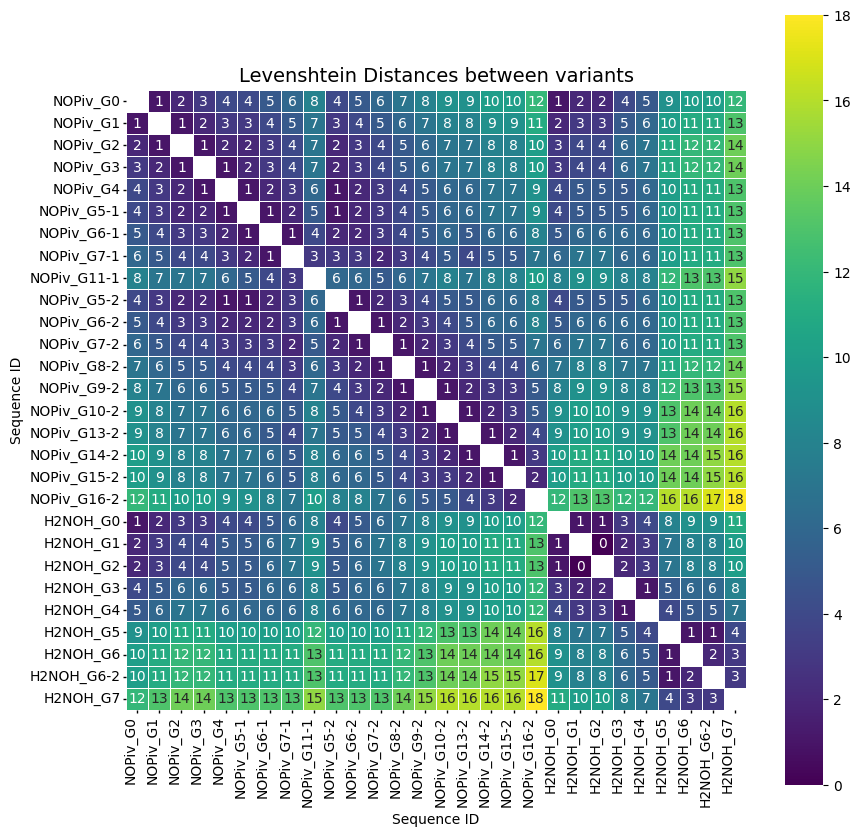

In [5]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_df, annot=True, fmt=".0f", cmap="viridis", cbar=True, square=True, ax=ax1,
            linewidths=0.5, linecolor="white")
ax1.set_title(f"Levenshtein Distances between variants", fontsize=14)
ax1.set_xlabel("Sequence ID")
ax1.set_ylabel("Sequence ID")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax1 = clean_plt(ax1)
plt.savefig(f'{fig_dir}heatmap_levenshtein_lineage.png', dpi=300)

# Look at the sequence function data and make heatmaps across the landscape

In [6]:


nopiv1_camp = ['NOPiv_G7-1']
nopiv2_camp = ['NOPiv_G13-2', 'NOPiv_G9-2', 'NOPiv_G10-2']
h2noh_camp  = ['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

def make_heatmap(df, label, remove_empty=False, vmin=-10, vmax=10, cmap='RdBu_r', figsize=(18, 4), column='Area plate standard norm', variants_to_highlight=None):
    # Now we want the actual number of positions we can do this by computing all numbers
    positions = []
    position_dict = defaultdict(list)
    position_to_value = defaultdict(dict)
    for subs, value in df[['amino_acid_substitutions', column]].values:
        for pos in subs.split('_'):
            # Only keep those that weren't retained
            positions.append(int(pos[1:-1]))
            position_dict[int(pos[1:-1])].append(pos[-1])
            if position_to_value[int(pos[1:-1])].get(pos[-1]):
                value = float(value)
                position_to_value[int(pos[1:-1])][pos[-1]].append(value)
            else:
                position_to_value[int(pos[1:-1])][pos[-1]] = []
                value = float(value)
                position_to_value[int(pos[1:-1])][pos[-1]].append(value)
    position_to_max_value = defaultdict(dict)
    for position, aas in position_to_value.items():
        for aa in aas:
            values = position_to_value.get(position).get(aa)
            position_to_max_value[position][aa] = float(np.nanmax(values))

    # Create an empty DataFrame for all letters and numbers
    letters = list("RHKDESTNQCGPAVILMFYW*")
    if remove_empty:
        numbers = list(position_dict.keys())
        numbers.sort()
    else:
        numbers = list(range(0, 204))  # 0 to 100
    
    # Initialize a DataFrame with zeros
    data = pd.DataFrame(0.0, index=letters, columns=numbers)
    
    highlight_cells = [] 

    # Fill the DataFrame with counts
    x = 0
    for number, letters_list in position_to_value.items():
        y = 0
        counts = Counter(letters_list)
        for letter, count in counts.items():
            data.at[letter, number] = float(np.nanmax(count)) #np.log(count)
            if variants_to_highlight:
                variant_str = f'{number}{letter}'
                if variant_str in variants_to_highlight:
                    row_idx = data.index.get_loc(letter)
                    col_idx = data.columns.get_loc(number)
                    highlight_cells.append((row_idx, col_idx))
            y += 1
        x += 1
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, linewidths=.25, cbar_kws={'label': column})
    if variants_to_highlight:        
        for (row, col) in highlight_cells:
            rect = Rectangle((col, row), 1, 1, fill=False, edgecolor='yellow', linewidth=2)
            ax.add_patch(rect)
            
    plt.xlabel("Residue position")
    plt.ylabel("Aminoacid substitution")
    plt.title(f"Positions explored across {label}")
    ax.set_yticks([y + 0.5 for y in range(data.shape[0])])
    ax.set_yticklabels(data.index, rotation=0)  # adjust rotation as needed
    if not remove_empty:
        xticks = range(0, data.shape[1], 5)
        ax.set_xticks([x + 0.5 for x in xticks])
        ax.set_xticklabels(data.columns[xticks], rotation=90)  # Adjust rotation for readability
    else:
        ax.set_xticks([x + 0.5 for x in range(data.shape[1])])
        ax.set_xticklabels(data.columns, rotation=90)  # adjust rotation as needed
    plt.tight_layout()
    plt.savefig(f'{fig_dir}heatmap_{label}_positions_area_norm.png', dpi=300)
    plt.show()

# Read in the DF and then remove variants that we don't want to plot

In [7]:
nn_df = pd.read_csv(f'{output_dir}LevSeq_CombinedDF_pdt_filtered.csv')
nn_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_well,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,# substitutions
0,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,A3,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.581206,1.461312,1
1,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,A4,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.703650,0.441502,1
2,1,G12-2-M86C-W62X,T184G_G185T_G186T_A256T_T257G_G258T,W62V,A9,0.904255,47.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,7.0,D4F-A9,...,A9,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,91746.0809,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.867991,0.311062,1
3,1,G12-2-M86C-W62X,T184A_G186T_A256T_T257G_G258T,W62S,A10,0.964103,39.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,8.0,D4F-A10,...,A10,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,100422.7253,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.830927,0.340480,1
4,1,G12-2-M86C-W62X,T184G_G185T_A256T_T257G_G258T,W62V,A11,0.937931,29.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,9.0,D4F-A11,...,A11,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,80172.7978,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.917428,0.271824,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,40,ep-P8,C5T,T2I,G4,0.846154,78.0,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,77.0,D6B-G4,...,G4,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,331518.9205,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.085983,0.756616,1
3599,40,ep-P8,C488T,S163L,G5,0.960000,75.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,78.0,D6B-G5,...,G5,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,291902.5909,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.860908,0.666201,1
3600,40,ep-P8,C202T_G499A,H68Y_V167I,H2,0.953901,141.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,87.0,D6B-H2,...,H2,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,101166.8328,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-6.591840,0.230890,2
3601,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93.0,D6B-H8,...,H8,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-7.047915,0.177677,2


# Plot various heatmaps

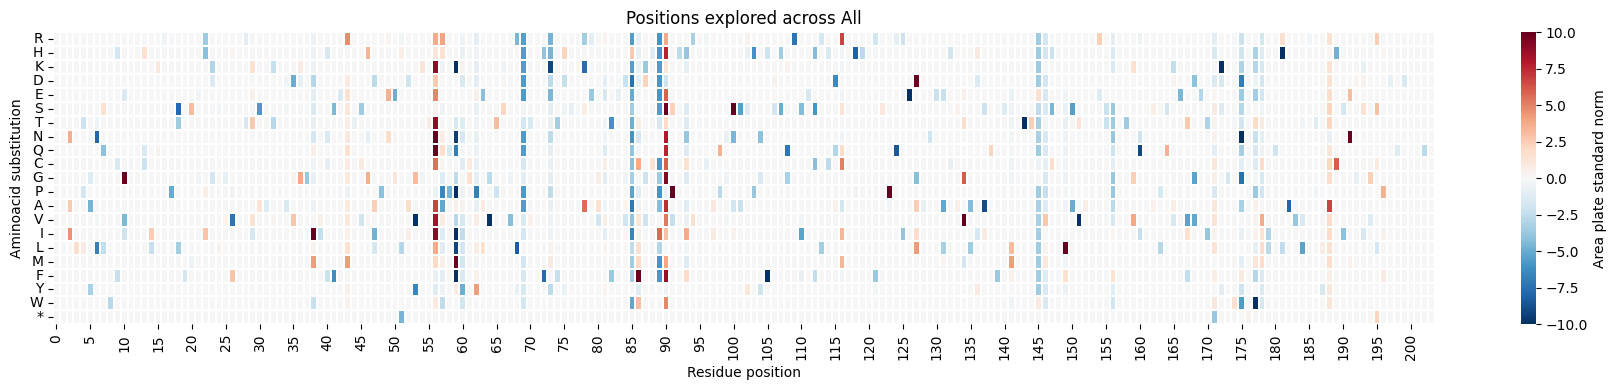

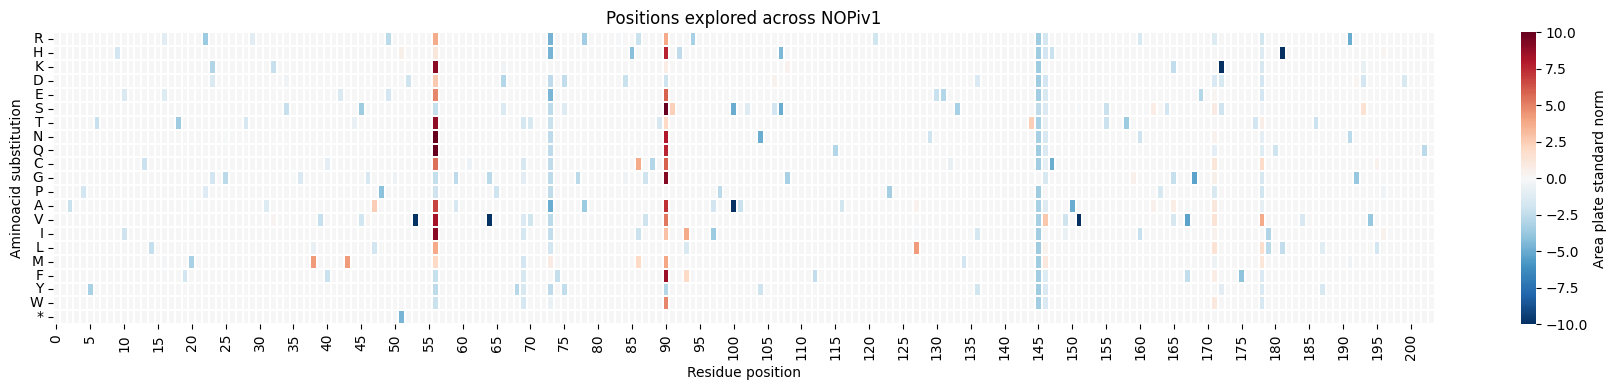

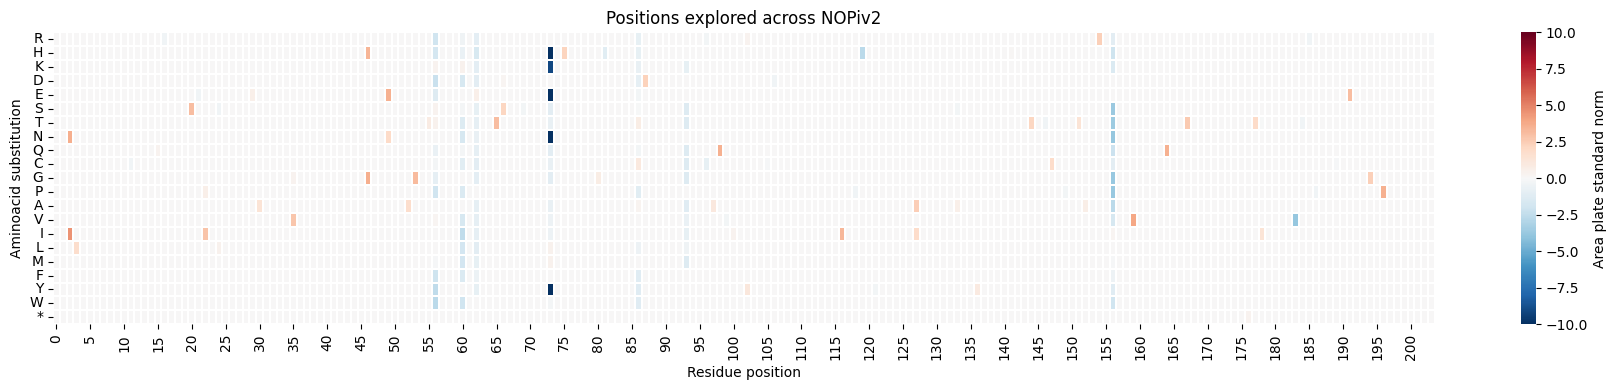

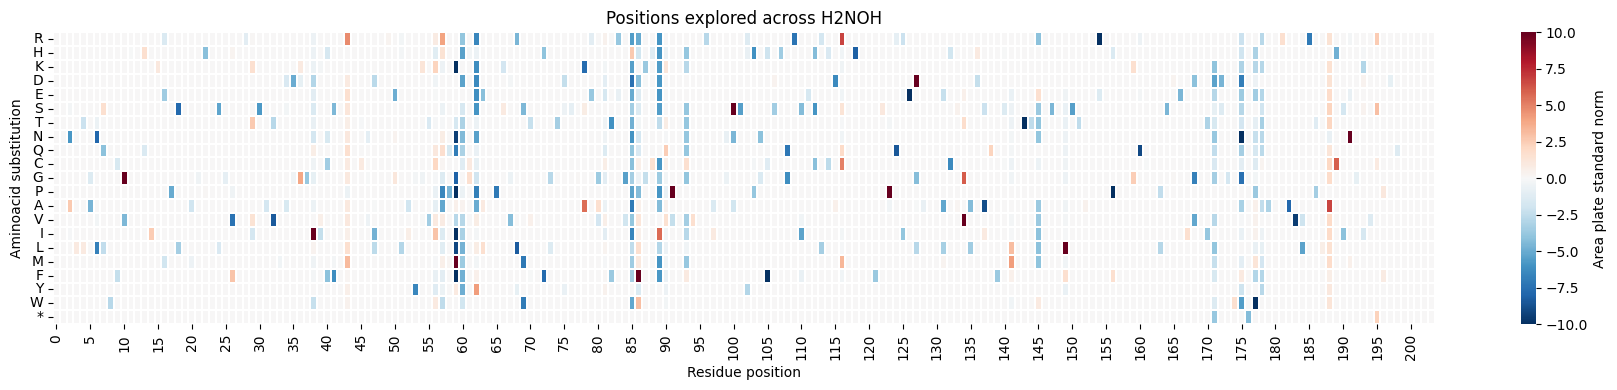

In [8]:
make_heatmap(nn_df, 'All') # Everything
make_heatmap(nn_df[nn_df['campaign_name'].isin(nopiv1_camp)], 'NOPiv1') # only the ones in those specific campaigns
make_heatmap(nn_df[nn_df['campaign_name'].isin(nopiv2_camp)], 'NOPiv2')
make_heatmap(nn_df[nn_df['campaign_name'].isin(h2noh_camp)], 'H2NOH')

# Now we only want to plot positives

For this, let's change the colour and also the ranges for the data.

In [9]:
h2noh_substitutions # We can see that these sites were not observed in the LevSeq analysis 61R (G5) 134A (G2) 167V (G5) 174L (G5) 20240603-JR-SSM

['2A',
 '29T',
 '59M',
 '61R',
 '62Y',
 '86F',
 '116R',
 '134A',
 '149L',
 '167V',
 '174L']

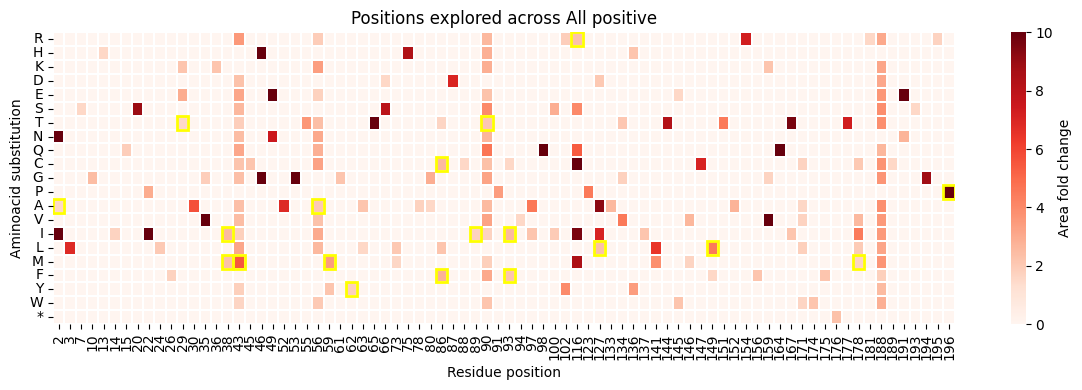

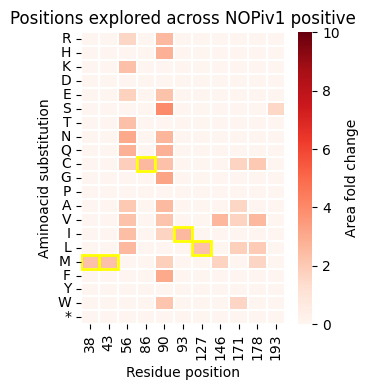

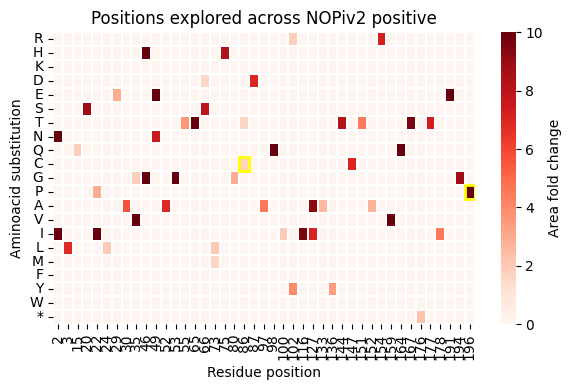

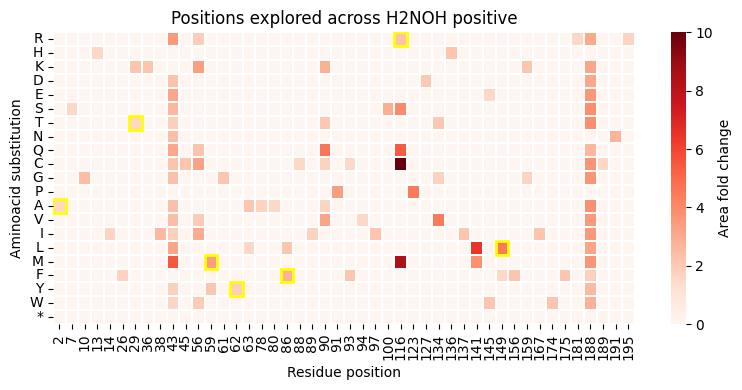

In [10]:
positive_df = nn_df[nn_df['Area fold change'] > 1.5]
make_heatmap(positive_df, 'All positive', vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(12, 4), column='Area fold change', 
            variants_to_highlight=nopiv1_substitutions + h2noh_substitutions + nopiv2_substitutions)
make_heatmap(positive_df[positive_df['campaign_name'].isin(nopiv1_camp)], 'NOPiv1 positive', vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(3.5, 4), 
             column='Area fold change', variants_to_highlight=nopiv1_substitutions)
make_heatmap(positive_df[positive_df['campaign_name'].isin(nopiv2_camp)], 'NOPiv2 positive',  vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(6, 4), 
             column='Area fold change', variants_to_highlight=nopiv2_substitutions)
make_heatmap(positive_df[positive_df['campaign_name'].isin(h2noh_camp)], 'H2NOH positive',  vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(8, 4), column='Area fold change' , 
             variants_to_highlight=h2noh_substitutions)

# Do the same but for negative data

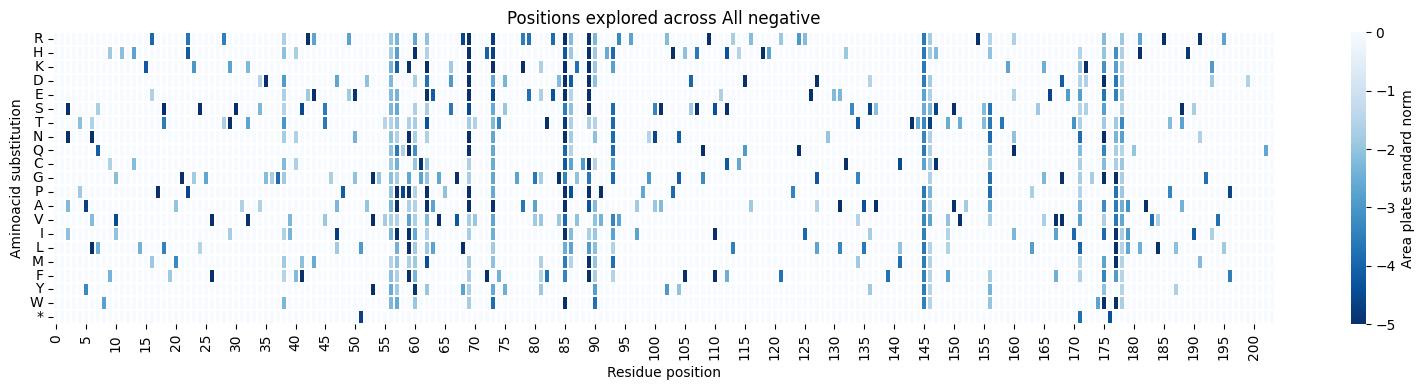

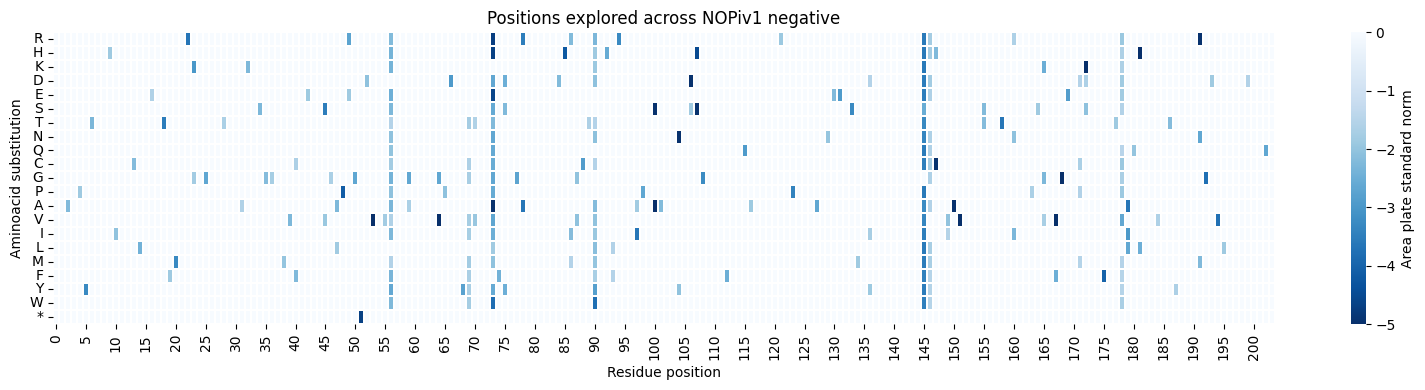

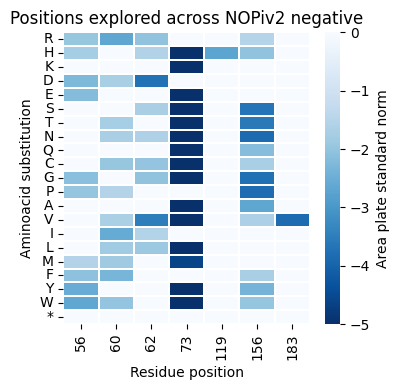

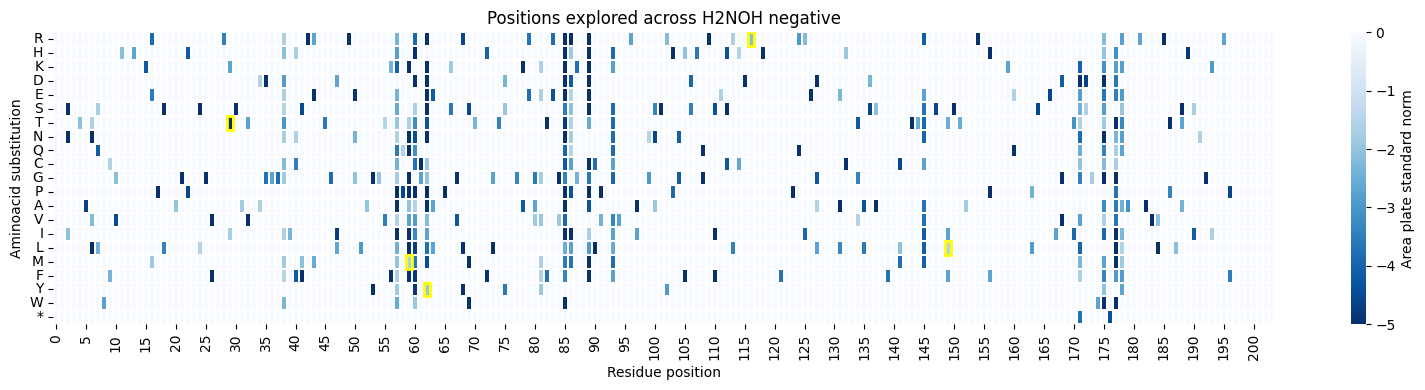

In [11]:
negative_df = nn_df[nn_df['Area plate standard norm'] < -1.5]
vmin = -5
vmax = 0
make_heatmap(negative_df, 'All negative', vmin=vmin, vmax=vmax, cmap='Blues_r', figsize=(16, 4))
make_heatmap(negative_df[negative_df['campaign_name'].isin(nopiv1_camp)], 'NOPiv1 negative', vmin=vmin, vmax=vmax, cmap='Blues_r', figsize=(16, 4))
make_heatmap(negative_df[negative_df['campaign_name'].isin(nopiv2_camp)], 'NOPiv2 negative',  vmin=vmin, vmax=vmax, cmap='Blues_r', remove_empty=True, figsize=(4, 4))
make_heatmap(negative_df[negative_df['campaign_name'].isin(h2noh_camp)], 'H2NOH negative',  vmin=vmin, vmax=vmax, cmap='Blues_r', figsize=(16, 4), variants_to_highlight=h2noh_substitutions)

# Next look at the combinations of mutations in the H2NOH campaign

We want to investigate the possible "missed" oppurtunities. 

- What we can do is look at which mutations conferred good activity and then see if they have occured with any others

- Note for visualizations we remove any positions which have already been "finalized"

In [12]:
positive_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L          57
A134V_I149L    15
V116R          13
V38I_I149L     12
A59M_I149L     10
               ..
T2I_D53G        1
K49N            1
L22I            1
T2N_D46G        1
A134T           1
Name: count, Length: 172, dtype: int64

In [13]:
positive_df['# substitutions'] = [len(pos.split('_')) for pos in positive_df['amino_acid_substitutions'].values]

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_91023/1260173900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['# substitutions'] = [len(pos.split('_')) for pos in positive_df['amino_acid_substitutions'].values]


In [14]:
mutli_subs = positive_df[positive_df['# substitutions'] > 1]
mutli_subs['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
A134V_I149L                                                                                           15
V38I_I149L                                                                                            12
A59M_I149L                                                                                            10
D10G_I149L                                                                                             5
T56L_M86C_T90R_F93I_M178V                                                                              4
A91P_I149L                                                                                             3
V127D_I149L                                                                                            3
V38I_A134V_I149L                                                                                       3
A91P_A134V_I149L                                                                                       3
T100S_I149L                   

# Check which positions were mutated in the lineage


In [15]:
# Now let's remove any which don't have at least one novel substitution
# i.e. it only has substitutions from the final 
novel_positions = []
for pos in positive_df['amino_acid_substitutions']:
    novel = False
    for p in pos.split('_'):
        if int(p[1:-1]) not in h2noh_substitutions:
            novel = True
    novel_positions.append(novel)
positive_df['novel_position'] = novel_positions
novel_positive_df = positive_df[positive_df['novel_position'] == True]
novel_positive_df

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_91023/1824936418.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['novel_position'] = novel_positions


,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,# substitutions,novel_position
70,3,G12-2-W62X-F73X,T184A_G185A_G186T_T217A_C219G,F73M,D10,0.973333,30.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,31.0,D3F-D10,...,3,JR-20241115-W62X-F73X_3.csv,20241115-JR-SSM-NOPiv,37958.6005,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.464878,1.591064,1,True
75,5,W62X-B1-ep300-1,A397G,T133A,A5,0.855072,69.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D5F-A5,...,5,JR-20241115_ep300-1_5.csv,20241115-JR-SSM-NOPiv,35005.6843,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.594648,2.546151,1,True
80,5,W62X-B1-ep300-1,G305A,C102Y,C5,0.875000,56.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,14.0,D5F-C5,...,5,JR-20241115_ep300-1_5.csv,20241115-JR-SSM-NOPiv,54496.2739,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,1.139876,3.963805,1,True
81,5,W62X-B1-ep300-1,A196G,N66D,C7,1.000000,19.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,16.0,D5F-C7,...,5,JR-20241115_ep300-1_5.csv,20241115-JR-SSM-NOPiv,21234.8179,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.209422,1.544522,1,True
82,5,W62X-B1-ep300-1,G346A,V116I,C9,0.956522,23.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,17.0,D5F-C9,...,5,JR-20241115_ep300-1_5.csv,20241115-JR-SSM-NOPiv,131750.0706,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,3.300969,9.582887,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,7,"L86X,V89X",C256T_G258T,L86F,A10,0.970588,51.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,11.0,D4F-A10,...,7,"L86X,V89X_7.csv",20240517-JR-SSM-H2NOH,122583.3755,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G3,10.995450,2.803763,1,True
2991,5,"V38X,W62X",G175A_C176T,A59M,D4,0.964467,197.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,41.0,D3F-D4,...,5,A59X-D57X_5.csv,20240421-JR-SSM-H2NOH,327523.5564,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G2,6.897857,1.635199,1,True
3433,33,ep-P1,A4G_T86C,T2A_M29T,F6,0.908046,87.0,MAPSDIPGYDYGRVEKSPITDLEFDLLKTTVMLGEEDVMYLKKAAD...,67.0,D3F-F6,...,33,20250403_HMC_epPCR_PA_P1_33.csv,20250404_epPCR-H2NOH,835287.1101,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,2.592759,1.533480,2,True
3572,39,ep-P7,T102C_A128T,K43M,C10,0.721053,95.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKMAAD...,35.0,D6F-C10,...,39,20250403_HMC_epPCR_PA_P7_39.csv,20250404_epPCR-H2NOH,498256.9867,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,0.997843,1.602401,1,True


In [16]:
novel_positive_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L          57
A134V_I149L    15
V116R          13
V38I_I149L     12
A59M_I149L     10
               ..
T2I_D53G        1
K49N            1
L22I            1
T2N_D46G        1
A134T           1
Name: count, Length: 172, dtype: int64

In [17]:
mutli_subs = novel_positive_df[novel_positive_df['# substitutions'] > 1]
mutli_subs['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
A134V_I149L                                                                                           15
V38I_I149L                                                                                            12
A59M_I149L                                                                                            10
D10G_I149L                                                                                             5
T56L_M86C_T90R_F93I_M178V                                                                              4
A91P_I149L                                                                                             3
V127D_I149L                                                                                            3
V38I_A134V_I149L                                                                                       3
A91P_A134V_I149L                                                                                       3
T100S_I149L                   

# Visualize this now

In [18]:
df = novel_positive_df[novel_positive_df['campaign_name'].isin(h2noh_camp)]
rows = []
for pos, value in df[['amino_acid_substitutions', 'Area fold change']].values:
    positions = pos.split('_')
    for i in positions:
        rows.append([pos, int(i[1:-1]), i[-1], float(value), len(pos.split('_'))])
vis_df = pd.DataFrame(rows, columns=['amino_acid_substitutions', 'position', 'aa', 'value', '# substiutions'])
vis_df = vis_df.sort_values(by='position')

In [19]:
h2noh_positions = [int(x[:-1]) for x in h2noh_substitutions]

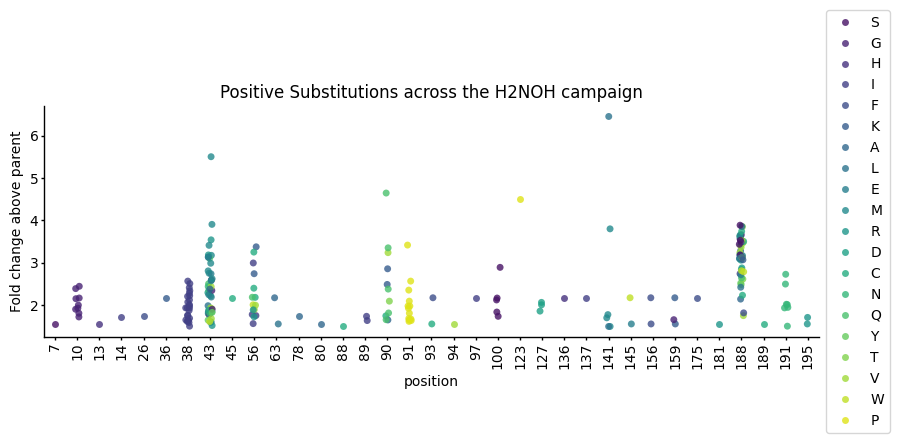

In [24]:
vis_df = vis_df[~vis_df['position'].isin(h2noh_positions)]
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
plt.figure(figsize=(10, 3))
ax = sns.stripplot(vis_df, x='position', y='value', hue='aa', palette='viridis', alpha=0.8)
clean_plt(ax)
plt.ylabel('Fold change above parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Positive Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign'.replace(' ', '_') + '.png', dpi=300, bbox_inches='tight')

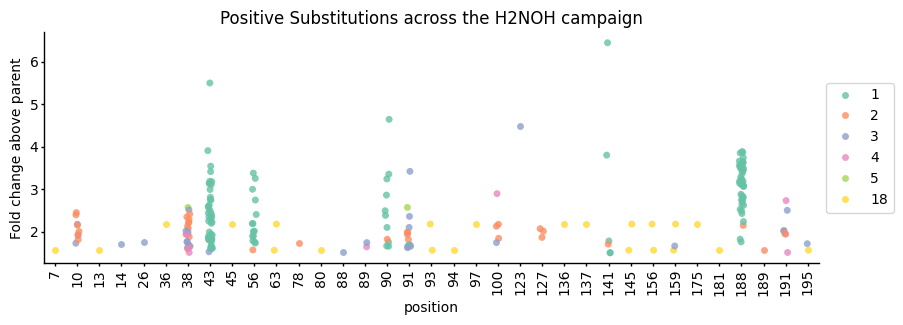

In [25]:
plt.figure(figsize=(10, 3))
ax = sns.stripplot(vis_df, x='position', y='value', hue='# substiutions', alpha=0.8, palette='Set2')
clean_plt(ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Fold change above parent')
plt.title('Positive Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.png', dpi=300, bbox_inches='tight')

In [22]:
# Do the same but for the negative so we can see whether we have negative data also for these positions
df = negative_df[negative_df['campaign_name'].isin(h2noh_camp)]
rows = []
for pos, value in df[['amino_acid_substitutions', 'Area plate standard norm']].values:
    for i in pos.split('_'):
        rows.append([pos, int(i[1:-1]), i[-1], float(value), len(pos.split('_'))])
negative_vis_df = pd.DataFrame(rows, columns=['amino_acid_substitutions', 'position', 'aa', 'value', '# substiutions'])
negative_vis_df = negative_vis_df.sort_values(by='position')
positive_positions = [int(p) for p in positive_positions]
negative_positions = [int(i) for i in negative_vis_df['position'].values]
negative_vis_df['position'] = negative_positions
negative_vis_df = negative_vis_df.sort_values(by='position')
negative_vis_df = negative_vis_df[negative_vis_df['position'].isin(positive_positions)]
negative_vis_df

,amino_acid_substitutions,position,aa,value,# substiutions
1510,P7Q_Y40F_E168D_T190I,7,Q,-4.125067,4
95,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,7,S,-5.512855,17
971,P7L_Y9C,7,L,-2.456966,2
962,P7S_Q113R_T190S,7,S,-1.725602,3
142,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,7,S,-2.738083,18
...,...,...,...,...,...
377,V38I_V89I_W93L_I149L_V178L_K191N_L196F,191,N,-3.478564,7
1570,D10G_M29T_Y40C_K42R_W195R,195,R,-7.320881,5
179,P7S_R13H_M29K_R61G_V63L_E80A_F86L_W93C_G94V_A1...,195,R,-2.746803,18
159,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,195,R,-2.738083,18


In [23]:
vis_df = vis_df[~vis_df['position'].isin(positions_h2noh)]
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
negative_vis_df['position'] = [str(int(p)) for p in negative_vis_df['position'].values]
df = pd.concat([negative_vis_df, vis_df])
plt.figure(figsize=(10, 3))
ax = sns.stripplot(df, x='position', y='value', hue='aa', alpha=0.8, palette='viridis')
plt.ylabel('Fold change above parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

clean_plt(ax)
plt.title('Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Substitutions across the H2NOH campaign - aa'.replace(' ', '_') + '.png', dpi=300)

NameError: name 'positions_h2noh' is not defined

In [ ]:
vis_df = vis_df[~vis_df['position'].isin(positions_h2noh)]
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
negative_vis_df['position'] = [str(int(p)) for p in negative_vis_df['position'].values]
df = pd.concat([negative_vis_df, vis_df])
plt.figure(figsize=(10, 3))
ax = sns.stripplot(df, x='position', y='value', hue='# substiutions', palette='Set2')
plt.ylabel('Fold change above parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

clean_plt(ax)
plt.title('Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.png', dpi=300)